In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading CSV tables
admissions = pd.read_csv("./data/ADMISSIONS.csv")
patients = pd.read_csv("./data/PATIENTS.csv")
services = pd.read_csv("./data/SERVICES.csv")
icustays = pd.read_csv("./data/ICUSTAYS.csv")
drgcodes = pd.read_csv("./data/DRGCODES.csv")
prescriptions = pd.read_csv("./data/PRESCRIPTIONS.csv")
microbiologyevents = pd.read_csv("./data/MICROBIOLOGYEVENTS.csv")

In [3]:
# cos mi tu nie pasowało bo w df mamy 402 wiersze a jest 129 przyjec

In [4]:
# Dokonamy imputacji zmiennych kategorycznych
admissions['language'] = admissions['language'].fillna('Missing_language')
admissions['religion'] = admissions['religion'].fillna('Missing_religion') 
admissions['marital_status'] = admissions['marital_status'].fillna('Missing_marital_status')
microbiologyevents['interpretation'] = microbiologyevents['interpretation'].fillna("BRAK")
services['prev_service'] = services['prev_service'].fillna("BRAK")

In [5]:
# Dokonamy imputacji zmiennych ciągłych
drgcodes.drg_severity.fillna(drgcodes.drg_severity.median(), inplace=True)
drgcodes.drg_mortality.fillna(drgcodes.drg_mortality.median(), inplace=True)

### Wybieramy interesujące nasz kolumny

In [6]:
admissions_opt = admissions[['subject_id', 'hadm_id', 'admission_type' ,
                             "insurance", "language", "religion",
                             "marital_status", "ethnicity", "hospital_expire_flag",
                             'admittime', ]]
patients_opt = patients[['subject_id', "gender", "dob"]]
services_opt = services[['row_id', 'subject_id', 'hadm_id', 'prev_service', 'curr_service']]
icustays_opt = icustays[['subject_id', 'hadm_id', 'los']]
drgcodes_opt = drgcodes.drop(['description', 'row_id', 'drg_code'], axis = 1)
prescriptions_opt = prescriptions[['subject_id', 'hadm_id', 'drug_type']]
microbiologyevents_opt = microbiologyevents[['subject_id', 'hadm_id', 'interpretation']]

### Kodujemy i grupujemy zmienne będące w wybranych przez nas tabelach

In [7]:
from sklearn.preprocessing import OneHotEncoder

def encode_and_join(encode, df):
    enc = OneHotEncoder(handle_unknown='ignore')
    
    enc_df = pd.DataFrame(
        enc.fit_transform(df[encode]).toarray(),
        columns = enc.get_feature_names(input_features = encode)
    )
    
    return df.join(enc_df).drop(encode, axis = 1)

- admissions

In [8]:
encode = ["admission_type", "insurance", "language", "religion", "marital_status", "ethnicity"]
admissions_opt = encode_and_join(encode , admissions_opt)

- patients

In [9]:
encode = ['gender']
patients_opt['gender'] = patients_opt['gender'].astype('category').cat.codes

- services

In [10]:
encode = ['prev_service', 'curr_service']
services_opt = encode_and_join(encode, services_opt)

services_opt = services_opt.groupby(by = ['subject_id','hadm_id']).sum().reset_index().drop('row_id', axis = 1)
services_opt.shape

(129, 24)

- icustays

In [11]:
icustays_opt = icustays_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
icustays_opt.shape

(129, 3)

- drgcodes

In [12]:
encode = ['drg_type']
drgcodes_opt = encode_and_join(encode, drgcodes_opt)

drgcodes_opt = drgcodes_opt.groupby(
    by = ['subject_id', 'hadm_id'])[['drg_severity', 'drg_mortality']].mean().join(
    drgcodes_opt.groupby(by = ['subject_id', 'hadm_id']).sum().drop(['drg_severity', 'drg_mortality'], axis = 1)
).reset_index()
drgcodes_opt.shape

(129, 7)

- prescriptions

In [13]:
encode = ['drug_type']
prescriptions_opt = encode_and_join(encode, prescriptions_opt)

prescriptions_opt = prescriptions_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
prescriptions_opt.shape # nie kazdy pacjent otrzymal recepte

(122, 5)

In [14]:
encode = ['interpretation']

microbiologyevents_opt = encode_and_join(encode, microbiologyevents_opt)
microbiologyevents_opt = microbiologyevents_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
microbiologyevents_opt.shape # nie każde przyjęcie testowało tą zmienną, trzeba będzie później nadpisać NA

(120, 6)

### Łączymy wszystkie tabele

In [15]:
df2 = admissions_opt.join(patients_opt.set_index("subject_id"), on = "subject_id")
df2 = df2.join(services_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(icustays_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(drgcodes_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(prescriptions_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(microbiologyevents_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])

In [16]:
# przypisujemy każdej wzycie 0 przypisanych recept skoro nie zostaly one zanotowane
df2.drug_type_ADDITIVE.fillna(0, inplace=True)
df2.drug_type_BASE.fillna(0, inplace=True)
df2.drug_type_MAIN.fillna(0, inplace=True)
# to samo z interpretation
df2.interpretation_BRAK.fillna(1, inplace=True)
df2.interpretation_I.fillna(0, inplace=True)
df2.interpretation_R.fillna(0, inplace=True)
df2.interpretation_S.fillna(0, inplace=True)

In [17]:
# dodajemy zmienna age zamiast dob i admittime

In [18]:
from datetime import datetime

df2['admittime'] =  pd.to_datetime(df2['admittime'], format='%Y-%m-%d')
df2['dob'] =  pd.to_datetime(df2['dob'], format='%Y-%m-%d')
length = df2["admittime"].apply(lambda x: x.year) - df2["dob"].apply(lambda x: x.year)
df2['age'] = length
# Patients who are older than 89 years old - 300 years
df2.age = df2.age.replace(300, 90)

df2 = df2.drop(['admittime', 'dob'], axis=1)


In [19]:
# chyba lepiej przewidywać na podstawie tych 129 przyjęć, bo nie wiem co te 402 wiersze oznaczały dokładnie

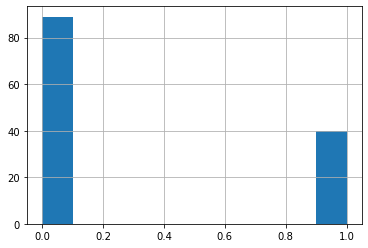

In [20]:
df2.hospital_expire_flag.hist()
plt.show()

In [21]:
#tables joins to data frame
df = admissions.join(patients.set_index("subject_id"), on = "subject_id", lsuffix="_adm", rsuffix="_pat")
df = df.join(services.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df = df.join(icustays.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"], rsuffix="_icu")
df = df.join(drgcodes.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"], rsuffix="_drg")

Kilka luźnych uwag do zanotowania:
- część zmiennych tworzy wiele rekordów do pojedynczego pobytu pacjenta (np. curr_service, te od kodów DRG), a df musi mieć formę: wiersz opisujący pobyt pacjenta - target 
- trzeba te zmienne zagregować albo z nich zrezygnować
- z tych powodów nie wziąłem np microbiology events
- zmiennych jest 15 więc spokojnie może coś odpaść przy EDA
- CSVki w folderze jak wyżej umieście i nie wrzucamy go na repo, jak będziemy mieli docelowy df to wtedy trzeba zapisać do CSV i na repo
- jak jakieś inne zmienne itp. to kodu wiele nie ma wiadomo co i gdzie możecie zmieniać

In [22]:
df = df[[
    #identyfikator pobytu pacjenta: subject_id + hadm_id
    "subject_id", "hadm_id",
    ###ADMISSIONS
    #czas przyjęcia, wypisu
    "admittime", "dischtime",
    #typ pobytu
    "admission_type",
    #dane personalne
    "insurance", "language", "religion", "marital_status", "ethnicity",
    #TARGET zmienna binarna śmierć w szpitalu
    "hospital_expire_flag",
    ###PATIENTS
    "gender", 
    #data urodzenia
    "dob",
    ###SERVICES
    #opieka/zabieg
    "curr_service",
    ###ICUSTAYS
    #długość pobytu na ICU
    "los",
    ###DRGCODES
    #para identyfikująca 
    "drg_type", "drg_code",
    "drg_severity", "drg_mortality"
]]

In [23]:
df

,subject_id,hadm_id,admittime,dischtime,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,dob,curr_service,los,drg_type,drg_code,drg_severity,drg_mortality
0,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,2094-03-05 00:00:00,MED,1.6325,HCFA,416,4.0,3.0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,Private,Missing_language,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,2090-06-05 00:00:00,MED,13.8507,HCFA,205,4.0,3.0
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,Missing_marital_status,UNKNOWN/NOT SPECIFIED,1,F,2038-09-03 00:00:00,MED,2.6499,HCFA,416,4.0,3.0
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,APR,3153,3.0,3.0
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,HCFA,491,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,APR,2013,3.0,3.0
127,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,MS,308,4.0,3.0
128,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0
128,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0


Zmienna celu to: hospital_expire_flag

W kolumnach language, religion, marital_status, drg_severity i drg_mortality mamy braki danych

In [24]:
from datetime import datetime

# to chyba jest już nie potrzebne 
# kolumna LOS trzyma długość pobytu w dniach

df['admittime'] =  pd.to_datetime(df['admittime'], format='%Y-%m-%d %H:%M:%S')
df['dischtime'] =  pd.to_datetime(df['dischtime'], format='%Y-%m-%d %H:%M:%S')
length = df["dischtime"] - df["admittime"]
length.rename("my_name")
df['length'] = length.dt.total_seconds()
df = df.drop(['admittime', 'dischtime'], axis=1)
df

,subject_id,hadm_id,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,dob,curr_service,los,drg_type,drg_code,drg_severity,drg_mortality,length
0,10006,142345,EMERGENCY,Medicare,Missing_language,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,2094-03-05 00:00:00,MED,1.6325,HCFA,416,4.0,3.0,763560.0
1,10011,105331,EMERGENCY,Private,Missing_language,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,2090-06-05 00:00:00,MED,13.8507,HCFA,205,4.0,3.0,1196820.0
2,10013,165520,EMERGENCY,Medicare,Missing_language,CATHOLIC,Missing_marital_status,UNKNOWN/NOT SPECIFIED,1,F,2038-09-03 00:00:00,MED,2.6499,HCFA,416,4.0,3.0,229020.0
3,10017,199207,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,APR,3153,3.0,3.0,696180.0
3,10017,199207,EMERGENCY,Medicare,Missing_language,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,HCFA,491,4.0,3.0,696180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,APR,2013,3.0,3.0,108300.0
127,44222,192189,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,MS,308,4.0,3.0,108300.0
128,44228,103379,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0,830760.0
128,44228,103379,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0,830760.0


In [25]:
df = df.drop(['dob'], axis=1)

In [26]:
# Dokonamy imputacji zmiennych kategorycznych
df['language'] = df['language'].fillna('Missing_language')
df['religion'] = df['religion'].fillna('Missing_religion') 
df['marital_status'] = df['marital_status'].fillna('Missing_marital_status') 

In [27]:
# Dokonamy imputacji zmiennych ciągłych
df.drg_severity.fillna(df.drg_severity.median(), inplace=True)
df.drg_mortality.fillna(df.drg_mortality.median(), inplace=True)

In [28]:
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

columns_to_encode = ['admission_type', 'insurance', 'curr_service', 'drg_type', 'ethnicity', 'gender', 'language', 'religion', 'marital_status', 'drg_severity', 'drg_mortality']

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(
    enc.fit_transform(df[columns_to_encode]).toarray(),
    columns = enc.get_feature_names(input_features = columns_to_encode)
)

enc_df = df.join(enc_df).drop(columns_to_encode, axis = 1)


In [29]:
enc_df

,subject_id,hadm_id,hospital_expire_flag,los,drg_code,length,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,curr_service_CMED,curr_service_CSURG,curr_service_GU,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,curr_service_TSURG,curr_service_VSURG,drg_type_APR,drg_type_HCFA,drg_type_MS,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,gender_F,gender_M,language_ENGL,language_MAND,language_Missing_language,language_POLI,language_RUSS,language_SPAN,religion_BUDDHIST,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_JEWISH,religion_MUSLIM,religion_Missing_religion,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_Missing_marital_status,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,drg_severity_2.0,drg_severity_3.0,drg_severity_4.0,drg_mortality_1.0,drg_mortality_2.0,drg_mortality_3.0,drg_mortality_4.0
0,10006,142345,0,1.6325,416,763560.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,10011,105331,1,13.8507,205,1196820.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,10013,165520,1,2.6499,416,229020.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10017,199207,0,2.1436,3153,696180.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10017,199207,0,2.1436,491,696180.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,0,1.3279,2013,108300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
127,44222,192189,0,1.3279,308,108300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
128,44228,103379,0,4.6191,7203,830760.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0

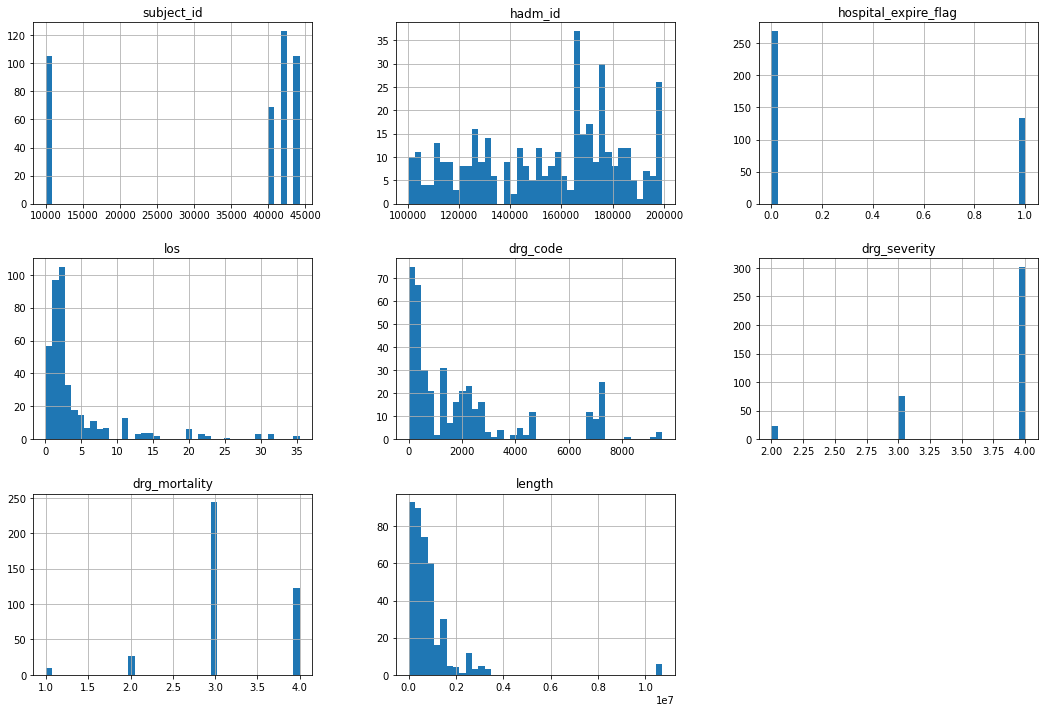

In [30]:
df.hist(bins = 40, figsize=(18, 12))

plt.show()

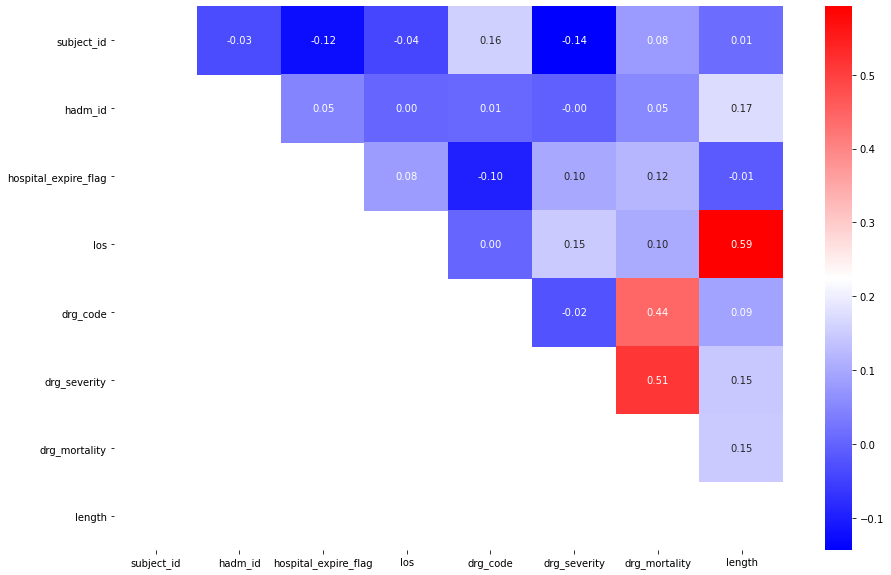

In [31]:
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool)).transpose()

plt.subplots(figsize=(15,10))
sns.heatmap(df_corr, mask = mask, cmap = 'bwr', annot=True, fmt='.2f')
plt.show()

* drg_severity jest dodatnio skorelowany z drg_mortality

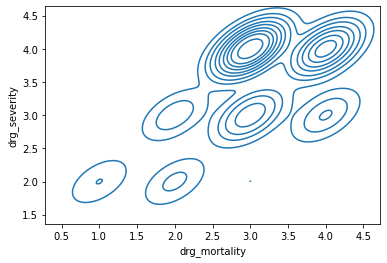

In [32]:
# Zobaczymy odkryte zależności na wykresach punktowych

sns.kdeplot(data = df, y="drg_severity", x="drg_mortality")
plt.show()

Można zauważyć tą korelacje

### Modele

In [33]:
y = np.array(df2['hospital_expire_flag'])
X = df2.drop(['hospital_expire_flag', 'subject_id', 'hadm_id'],axis=1)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
X.head()

,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,language_ENGL,language_MAND,language_Missing_language,language_POLI,language_RUSS,language_SPAN,religion_BUDDHIST,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_JEWISH,religion_MUSLIM,religion_Missing_religion,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_Missing_marital_status,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,gender,prev_service_BRAK,prev_service_CMED,prev_service_CSURG,prev_service_MED,prev_service_NMED,prev_service_NSURG,prev_service_OMED,prev_service_SURG,prev_service_TSURG,prev_service_VSURG,curr_service_CMED,curr_service_CSURG,curr_service_GU,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,curr_service_TSURG,curr_service_VSURG,los,drg_severity,drg_mortality,drg_type_APR,drg_type_HCFA,drg_type_MS,drug_type_ADDITIVE,drug_type_BASE,drug_type_MAIN,interpretation_BRAK,interpretation_I,interpretation_R,interpretation_S,age
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6325,4.0,3.0,0.0,1.0,0.0,0.0,9.0,45.0,13.0,1.0,3.0,3.0,70
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.8507,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,36
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6499,4.0,3.0,0.0,1.0,0.0,0.0,12.0,24.0,3.0,0.0,0.0,0.0,87
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.1436,3.5,3.0,1.0,1.0,0.0,0.0,18.0,87.0,2.0,0.0,0.0,0.0,74
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2938,4.0,3.0,0.0,1.0,0.0,10.0,40.0,49.0,3.0,0.0,1.0,9.0,49


### Dummy Classifier

In [36]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='prior', random_state=42)
dc.fit(X_train,y_train)
y_hat = dc.predict(X_test)
print('\ny:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))


y:     [0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0]
y_hat: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
dc.score(X_test, y_test)

0.7692307692307693

In [38]:
# Całkiem dobrze działa :) 

### Regresja logistyczna

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, random_state=0)

lr.fit(X_train,y_train)
y_hat = lr.predict(X_test)
print('y:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))

y:     [0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0]
y_hat: [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0]


In [40]:
lr.score(X_test, y_test)

0.717948717948718

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 0)

rfc.fit(X_train,y_train)
y_hat = rfc.predict(X_test)
print('y:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))

y:     [0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0]
y_hat: [0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0]


In [42]:
rfc.score(X_test, y_test)

0.6923076923076923

### Wybór hiperparametrów

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = dict(C=uniform(loc=0, scale=4),
                     solver = ["lbfgs", "saga"],
                     penalty=['l2', 'l1', 'elasticnet'])

clf = RandomizedSearchCV(lr, distributions, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'C': 2.4110535042865755, 'penalty': 'l1', 'solver': 'saga'}

In [44]:
lr_tunned = LogisticRegression(max_iter=1000, random_state=0, 
                               C = search.best_params_['C'], 
                               penalty = search.best_params_['penalty'],
                               solver = search.best_params_['solver'])

In [45]:
from scipy.stats import randint

distributions = dict(n_estimators = randint(10, 200),
                     criterion = ["gini", "entropy"])

clf = RandomizedSearchCV(rfc, distributions, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'entropy', 'n_estimators': 77}

In [46]:
rfc_tunned = RandomForestClassifier(random_state = 0, 
                            criterion = search.best_params_['criterion'],
                            n_estimators = search.best_params_['n_estimators'])

### Kroswalidacja

#### Bez wyboru hiperparametrów

In [47]:
import sklearn.metrics

sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [48]:
metric = 'roc_auc'

In [49]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(dc, X_train, y_train, scoring=metric, cv = 5)

print("DummyClassifier")
print(f"Mean : {np.mean(results)}")
print(f"Min : {np.min(results)}")

DummyClassifier
Mean : 0.5
Min : 0.5


In [50]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(lr, X_train, y_train, scoring=metric, cv = 5)

print("LogisticRegression")
print(f"Mean : {np.mean(results)}")
print(f"Min : {np.min(results)}")

LogisticRegression
Mean : 0.7104256854256855
Min : 0.625


In [51]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(rfc, X_train, y_train, scoring=metric, cv = 5)

print("RandomForestClassifier")
print(f"Mean : {np.mean(results)}")
print(f"Min : {np.min(results)}")

RandomForestClassifier
Mean : 0.7621572871572871
Min : 0.6875


#### Z wyborem hiperparametrów

In [52]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(lr_tunned, X_train, y_train, scoring=metric, cv = 5)

print("LogisticRegression")
print(f"Mean : {np.mean(results)}")
print(f"Min : {np.min(results)}")

LogisticRegression
Mean : 0.8017316017316016
Min : 0.6753246753246753


In [53]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(rfc_tunned, X_train, y_train, scoring=metric, cv = 5)

print("RandomForestClassifier")
print(f"Mean : {np.mean(results)}")
print(f"Min : {np.min(results)}")

RandomForestClassifier
Mean : 0.7776154401154401
Min : 0.7361111111111112
